In [1]:
import torch
import pandas as pd
import numpy as np
import pickle, logging, spacy, sys, os, json, requests
import matplotlib.pyplot as plt

from helpers.classes import Collection
from tqdm import tqdm
from bs4 import BeautifulSoup
from datetime import datetime

In [2]:
from helpers.cloze_generation import generate_clozes_from_point, named_entity_answer_generator as ne_answer_generator, noun_phrase_answer_generator as np_answer_generator

from helpers.table_processing import preprocess_table, read_process_table, find_relevant_column_header, find_relevant_content
from helpers.t5_language_model import summarise_t5_results


# df = pd.read_pickle('pickles/dataset_20210625_184837.pkl')
# clozes_df = pd.read_json('pickles/clozes_20210807_165700.json')

df = pd.read_pickle('pickles/collection_20210624_194932.pkl')
# clozes_df = pd.read_json('pickles/clozes_20210824.json')
clozes_df = pd.read_json('pickles/clozes_with_false_20210825.json') #contains negs

In [3]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('fivethirtyeight')

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

In [4]:
clozes_df

,cloze_text,source_text,true,false,answer_text,answer_type,answer_length,ids,bulletin,data
0,"In TEMPORALMASK, approximate gross value added...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In the years 2013 to 2017, approximate gross v...",2019,DATE,1,ccf75a2c157eacc5253f0e8a55b1ded9f5386d58,businessindustryandtrade/business/businessserv...,[/businessindustryandtrade/business/businessse...
1,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","£1,313.9 billion",MONEY,2,fc3346f2545ca5059bdb5150b998300c5001bea5,businessindustryandtrade/business/businessserv...,[/businessindustryandtrade/business/businessse...
2,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...",£42.8 billion,MONEY,2,81aa32270d547a368e7b806646c72069ba4fac43,businessindustryandtrade/business/businessserv...,[/businessindustryandtrade/business/businessse...
3,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...",3.4%,PERCENT,1,f308eb661ad1d6c8021cf9e22d8e8c7d9c5ff50e,businessindustryandtrade/business/businessserv...,[/businessindustryandtrade/business/businessse...
4,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...",2018,DATE,1,0a0bcf4b990f1926bc87fa662badadaf7e23d5fa,businessindustryandtrade/business/businessserv...,[/businessindustryandtrade/business/businessse...
...,...,...,...,...,...,...,...,...,...,...
6179,Around 6 in 10 people (61%) reported feeling s...,Around 6 in 10 people (61%) reported feeling s...,Around 6 in 10 people (61%) reported feeling s...,Around 6 in 10 people (61%) reported feeling s...,76%,PERCENT,1,dce8c5e1d183452a3cc887d90ff0f64ef4bb82b5,peoplepopulationandcommunity/wellbeing/article...,[/peoplepopulationandcommunity/wellbeing/datas...
6180,"In comparison, NUMERICMASK of people did not f...","In comparison, around 14% of people did not fe...","In comparison, around 14% of people did not fe...","In comparison, 46.6% of people did not feel si...",around 14%,PERCENT,2,e7c1fce9fcd8c918a07029ba4266c18391b1aa75,peoplepopulationandcommunity/wellbeing/article...,[/peoplepopulationandcommunity/wellbeing/datas...
6181,"In comparison, around 14% of people did not fe...","In comparison, around 14% of people did not fe...","In comparison, around 14% of people did not fe...","In comparison, around 14% of people did not fe...",38%,PERCENT,1,874948014cfa36eff9f493b57e8077f3bda23019,peoplepopulationandcommunity/wellbeing/article...,[/peoplepopulationandcommunity/wellbeing/datas...
6182,Some of the main UK findings (Source: IDENTITY...,Some of the main UK findings (Source: Understa...,Some of the main UK findings (Source: Understa...,Some of the main UK findings (Source: NHS Isle...,Understanding Society,ORG,2,fab3e03bd458df568f3d110940583bc1251dfd90,peoplepopulationandcommunity/wellbeing/article...,[/peoplepopulationandcommunity/wellbeing/datas...


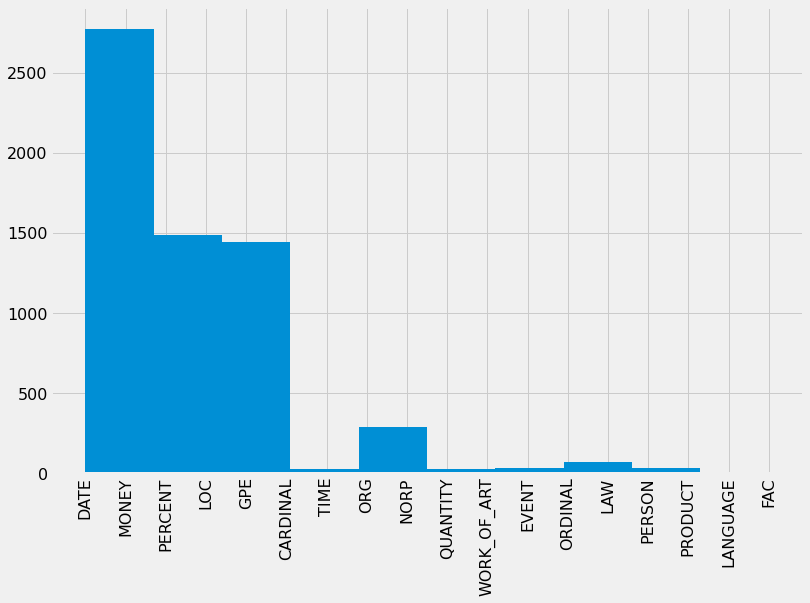

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.hist(clozes_df.answer_type)
plt.xticks(rotation = 90)
plt.show()

In [23]:
source_lengths = [len(x)for x in clozes_df.source_text]

lengths = pd.DataFrame({'lens': source_lengths, 'type': clozes_df.answer_type})

<AxesSubplot:ylabel='Frequency'>

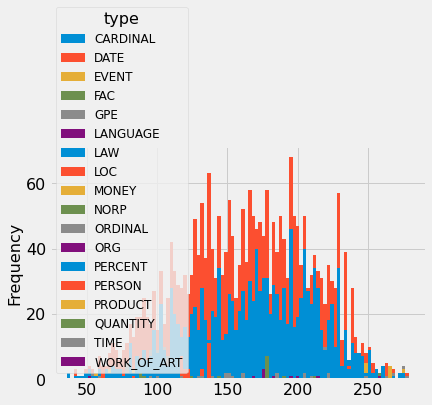

In [35]:
lengths.pivot(columns= 'type', values = 'lens').plot.hist(bins = 100)

In [37]:
clozes_df

,ids,cloze_text,source_text,answer_text,answer_type
0,ccf75a2c157eacc5253f0e8a55b1ded9f5386d58,"In TEMPORALMASK, approximate gross value added...","In 2019, approximate gross value added at basi...",2019,DATE
1,fc3346f2545ca5059bdb5150b998300c5001bea5,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","£1,313.9 billion",MONEY
2,81aa32270d547a368e7b806646c72069ba4fac43,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...",£42.8 billion,MONEY
3,f308eb661ad1d6c8021cf9e22d8e8c7d9c5ff50e,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...",3.4%,PERCENT
4,0a0bcf4b990f1926bc87fa662badadaf7e23d5fa,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...",2018,DATE
...,...,...,...,...,...
6179,dce8c5e1d183452a3cc887d90ff0f64ef4bb82b5,Around 6 in 10 people (61%) reported feeling s...,Around 6 in 10 people (61%) reported feeling s...,76%,PERCENT
6180,e7c1fce9fcd8c918a07029ba4266c18391b1aa75,"In comparison, NUMERICMASK of people did not f...","In comparison, around 14% of people did not fe...",around 14%,PERCENT
6181,874948014cfa36eff9f493b57e8077f3bda23019,"In comparison, around 14% of people did not fe...","In comparison, around 14% of people did not fe...",38%,PERCENT
6182,fab3e03bd458df568f3d110940583bc1251dfd90,Some of the main UK findings (Source: IDENTITY...,Some of the main UK findings (Source: Understa...,Understanding Society,ORG


In [7]:
answers_text_type = clozes_df[['answer_text', 'answer_type']].value_counts()

In [8]:
answers_text_type[answers_text_type.values > 10]

answer_text                 answer_type
England                     GPE            197
2019                        DATE           169
Wales                       GPE            157
2018                        DATE           136
London                      GPE             85
2017                        DATE            78
2020                        DATE            55
annual                      DATE            54
2016                        DATE            51
2014                        DATE            41
Scotland                    GPE             40
2015                        DATE            35
2011                        DATE            33
the previous year           DATE            33
first                       ORDINAL         28
Northern Ireland            GPE             26
second                      ORDINAL         25
100,000                     CARDINAL        24
the last year               DATE            24
CSEW                        ORG             24
2001                